In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [121]:

import os
# from google.colab import files
from zipfile import ZipFile
from tqdm import tqdm
import cv2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix


import tensorflow as tf
from tensorflow import keras

from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Input
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D,  GlobalAveragePooling2D
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from keras.applications import vgg19

import warnings
warnings.filterwarnings('ignore')

In [122]:
def processBlock(img, image_size=(224, 224), norm_type=cv2.NORM_MINMAX):
    """
    Finds the extreme points on the image and crops the rectangular out of them

    Args: image - source image
          image_size - resize the image to this
          norm_type - normalization to be applied on to the image

    Return: processed image
    """
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # threshold the image, then perform a series of erosions + dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)

    # find the extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    ADD_PIXELS = 0

    new_img = img[extTop[1] - ADD_PIXELS:extBot[1] + ADD_PIXELS, extLeft[0] - ADD_PIXELS:extRight[0] + ADD_PIXELS].copy()

    # resize image
    new_img = cv2.resize(new_img, image_size)

    # normalize image
    new_img = cv2.normalize(new_img, None, alpha=0, beta=1, norm_type=norm_type, dtype=cv2.CV_32F)
    return new_img

In [123]:

X = []
y = []
filename = []

In [124]:
os.chdir("/kaggle/input/brain-tumor-mri-dataset/Training")

In [125]:
sub_dirs= os.listdir()[::-1]
sub_dirs


['glioma', 'meningioma', 'notumor', 'pituitary']

In [126]:
dict_out = {}

for i in range(len(sub_dirs)):
    dict_out.update({sub_dirs[i]: i})
dict_out


{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [127]:
pip install imutils

Note: you may need to restart the kernel to use updated packages.


In [128]:
import imutils

In [129]:
for dirname in sub_dirs:
    print(dirname)
    for file_name in tqdm(os.listdir(dirname)):
        img = cv2.imread(os.path.join(dirname, file_name))
        img = processBlock(img)
        X.append(img)
        y.append(dirname)
        filename.append(file_name)

glioma


100%|██████████| 1321/1321 [00:10<00:00, 120.63it/s]


meningioma


100%|██████████| 1339/1339 [00:08<00:00, 167.36it/s]


notumor


100%|██████████| 1595/1595 [00:07<00:00, 205.43it/s]


pituitary


100%|██████████| 1457/1457 [00:13<00:00, 110.87it/s]


In [130]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)

In [132]:

print(f"Shape of images in X_train: {X_train[0].shape}")
print(f"Shape of images in X_test: {X_test[0].shape}")

Shape of images in X_train: (224, 224, 3)
Shape of images in X_test: (224, 224, 3)


In [133]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = to_categorical(y_train, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

y_train = np.array(y_train)
y_test = np.array(y_test)
X_train = np.array(X_train)
X_test = np.array(X_test)


In [134]:
desired_train_size = 2637
desired_test_size = 660

# Randomly select indices for the subset
train_indices = np.random.choice(len(X_train), desired_train_size, replace=False)
test_indices = np.random.choice(len(X_test), desired_test_size, replace=False)

# Create the subset of data
X_train = X_train[train_indices]
y_train = y_train[train_indices]
X_test = X_test[test_indices]
y_test = y_test[test_indices]

# Check the shapes of the new subsets
print(f"Shape of images in X_train: {X_train.shape}")
print(f"Shape of images in X_test_subset: {X_test.shape}")
print(f"Shape of images in y_train_subset: {y_train.shape}")
print(f"Shape of images in y_test_subset: {y_test.shape}")

Shape of images in X_train: (2637, 224, 224, 3)
Shape of images in X_test_subset: (660, 224, 224, 3)
Shape of images in y_train_subset: (2637, 4)
Shape of images in y_test_subset: (660, 4)


In [31]:
WIDTH, HEIGHT = (224, 224)


In [33]:

vgg = vgg19.VGG19(weights='imagenet',
                  include_top=False,
                  input_shape=(WIDTH, HEIGHT, 3))

for layer in vgg.layers:
    layer.trainable = False

In [34]:
for i, layer in enumerate(vgg.layers):
    print(f" {i} {layer.__class__.__name__, layer.trainable}")


 0 ('InputLayer', False)
 1 ('Conv2D', False)
 2 ('Conv2D', False)
 3 ('MaxPooling2D', False)
 4 ('Conv2D', False)
 5 ('Conv2D', False)
 6 ('MaxPooling2D', False)
 7 ('Conv2D', False)
 8 ('Conv2D', False)
 9 ('Conv2D', False)
 10 ('Conv2D', False)
 11 ('MaxPooling2D', False)
 12 ('Conv2D', False)
 13 ('Conv2D', False)
 14 ('Conv2D', False)
 15 ('Conv2D', False)
 16 ('MaxPooling2D', False)
 17 ('Conv2D', False)
 18 ('Conv2D', False)
 19 ('Conv2D', False)
 20 ('Conv2D', False)
 21 ('MaxPooling2D', False)


In [135]:
def topLayer(bottom_layer, num_classes):
    """
    Args:

    Returns:
    """
    top_layer = bottom_layer.output
    top_layer = GlobalAveragePooling2D()(top_layer)
    top_layer = Dense(2048, activation='relu')(top_layer)
    top_layer = Dense(1024, activation='relu')(top_layer)
    top_layer = Dense(512, activation='relu')(top_layer)
    top_layer = Dense(num_classes, activation='softmax')(top_layer)

    return top_layer

In [136]:

NUM_CLASSES = len(os.listdir("/kaggle/input/brain-tumor-mri-dataset/Training"))

In [137]:

model_head = topLayer(vgg, NUM_CLASSES)

In [38]:
model = Model(inputs=vgg.input, outputs=model_head)
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 2048)           │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 23,700,036 (90.41 MB)

 Trainable params: 3,675,652 (14.02 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [39]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [60]:

checkpoint_path = "D:/idp/vgg19best_weights.weights.h5"

In [61]:

model_checkpoint=tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=checkpoint_path,monitor='val_accuracy',mode='max',save_best_only=True,verbose=2)

In [57]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint(save_weights_only=True,filepath=checkpoint_path,monitor='val_accuracy',mode='max',save_best_only=True,verbose=2)

In [59]:
history = model.fit(X_train, y_train, epochs=20, batch_size=48, validation_data=(X_test, y_test))


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 9s 163ms/step - accuracy: 0.8746 - loss: 0.3326 - val_accuracy: 0.8364 - val_loss: 0.4487
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.8871 - loss: 0.3053 - val_accuracy: 0.8455 - val_loss: 0.4506
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.8830 - loss: 0.3019 - val_accuracy: 0.8500 - val_loss: 0.4301
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.8873 - loss: 0.3094 - val_accuracy: 0.8515 - val_loss: 0.4812
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9032 - loss: 0.2555 - val_accuracy: 0.8500 - val_loss: 0.4536
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 146ms/step - accuracy: 0.9091 - loss: 0.2461 - val_accuracy: 0.8470 - val_loss: 0.4362
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9026 - loss: 0.2542 - val_accuracy: 0.8409 - val_loss: 0.5609
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 8s 145ms/step - accuracy: 0.9179 - loss: 0.2231 - val_accuracy: 0

In [63]:
model.evaluate(X_test, y_test)

2024-04-28 18:30:50.540746: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.63498, expected 3.85968
2024-04-28 18:30:50.540802: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 6.55784, expected 5.78254
2024-04-28 18:30:50.540811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 6.61282, expected 5.83752
2024-04-28 18:30:50.540819: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 6.34499, expected 5.56968
2024-04-28 18:30:50.540827: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 6.25159, expected 5.47629
2024-04-28 18:30:50.540835: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 5.43964, expected 4.66434
2024-04-28 18:30:50.540843: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 6.54333, expected 5.76803
2024-04-28 18:30:50.540851: E external/local_xla/xla/se

20/21 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.8662 - loss: 0.5131

2024-04-28 18:31:07.250106: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50176: 3.79983, expected 3.15789
2024-04-28 18:31:07.250159: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50177: 5.13466, expected 4.49272
2024-04-28 18:31:07.250168: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50178: 4.78155, expected 4.13961
2024-04-28 18:31:07.250177: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50179: 4.88295, expected 4.24101
2024-04-28 18:31:07.250185: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50180: 4.73279, expected 4.09085
2024-04-28 18:31:07.250204: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50181: 4.69943, expected 4.05749
2024-04-28 18:31:07.250213: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 50182: 4.1975, expected 3.55556
2024-04-28 18:31:07.250221: 

21/21 ━━━━━━━━━━━━━━━━━━━━ 28s 631ms/step - accuracy: 0.8670 - loss: 0.5341


W0000 00:00:1714329077.687283     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


[0.7449082136154175, 0.8757575750350952]

In [64]:

from sklearn.metrics import classification_report
y_pred_prob = model.predict(X_test)

# Convert probabilities to class indices
y_pred = np.argmax(y_pred_prob, axis=1)

# Convert one-hot encoded y_test to class indices for comparison
y_test_indices = np.argmax(y_test, axis=1)

# Generate the classification report
report = classification_report(y_test_indices, y_pred, target_names=le.classes_)

print(report)


21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step
              precision    recall  f1-score   support

      glioma       0.85      0.85      0.85       149
  meningioma       0.81      0.73      0.77       135
     notumor       0.94      0.96      0.95       203
   pituitary       0.87      0.91      0.89       173

    accuracy                           0.88       660
   macro avg       0.87      0.86      0.86       660
weighted avg       0.87      0.88      0.87       660



W0000 00:00:1714329094.994992     122 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


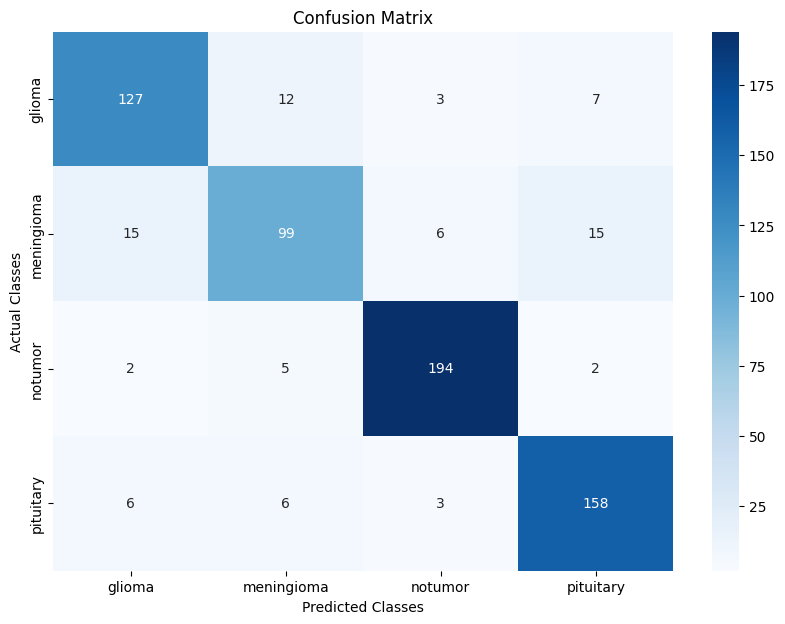

In [65]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


# In[ ]:


# Generate the confusion matrix
cm = confusion_matrix(y_test_indices, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()

In [73]:
def topLayer(bottom_layer, num_classes):
    """
    Define the top layers of the model for classification.

    Args:
        bottom_layer (keras.layers.Layer): The output tensor of the base model.
        num_classes (int): Number of classes for classification.

    Returns:
        keras.layers.Layer: The output tensor of the top layers.
    """
    top_layer = GlobalAveragePooling2D()(bottom_layer)
    top_layer = Dense(2048, activation='relu')(top_layer)
    top_layer = Dense(1024, activation='relu')(top_layer)
    top_layer = Dense(num_classes, activation='softmax')(top_layer)  # Final classification layer
    return top_layer


In [68]:

from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications import vgg16


# In[41]:


WIDTH, HEIGHT = (224, 224)
vgg_model = vgg16.VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(WIDTH, HEIGHT, 3))

for layer in vgg_model.layers:
    layer.trainable = False
model_head = topLayer(vgg_model.output, NUM_CLASSES)  # Pass output tensor instead of the model itself
model_vgg16 = Model(inputs=vgg_model.input, outputs=model_head)
model_vgg16.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# In[ ]:


history = model_vgg16.fit(X_train, y_train, epochs=20, batch_size=48, validation_data=(X_test, y_test))


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 13s 183ms/step - accuracy: 0.4794 - loss: 1.2889 - val_accuracy: 0.7697 - val_loss: 0.6192
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8123 - loss: 0.4977 - val_accuracy: 0.8167 - val_loss: 0.5159
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8475 - loss: 0.4049 - val_accuracy: 0.8242 - val_loss: 0.4676
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8180 - loss: 0.4235 - val_accuracy: 0.8470 - val_loss: 0.4192
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8799 - loss: 0.3216 - val_accuracy: 0.8591 - val_loss: 0.3847
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8896 - loss: 0.2967 - val_accuracy: 0.8576 - val_loss: 0.3763
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 121ms/step - accuracy: 0.8965 - loss: 0.2872 - val_accuracy: 0.8197 - val_loss: 0.4776
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - accuracy: 0.8792 - loss: 0.3198 - val_accuracy: 0

21/21 ━━━━━━━━━━━━━━━━━━━━ 3s 94ms/step - accuracy: 0.8789 - loss: 0.5712


W0000 00:00:1714330572.843575     120 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test Accuracy: 87.87878751754761%
21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step


W0000 00:00:1714330576.340395     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report
              precision    recall  f1-score   support

           0       0.90      0.85      0.88       149
           1       0.72      0.89      0.79       135
           2       0.99      0.91      0.95       203
           3       0.90      0.86      0.88       173

    accuracy                           0.88       660
   macro avg       0.88      0.88      0.87       660
weighted avg       0.89      0.88      0.88       660



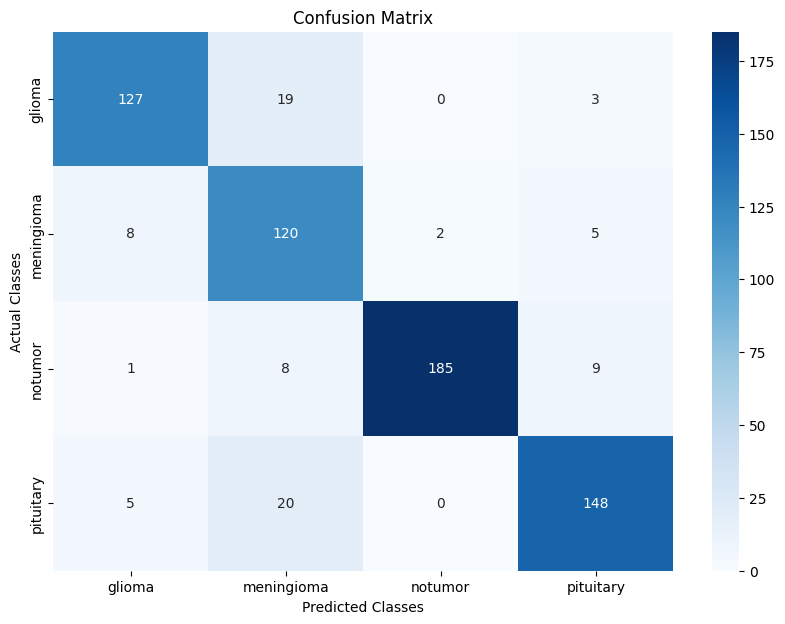

In [71]:
scores = model_vgg16.evaluate(X_test, y_test)
print(f"Test Accuracy: {scores[1]*100}%")


# In[ ]:


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


# In[ ]:


Y_pred = model_vgg16.predict(X_test)
# Convert predictions classes to one hot vectors
Y_pred_classes = np.argmax(Y_pred,axis = 1)
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_test,axis = 1)

# Classification report
print("Classification Report")
print(classification_report(Y_true, Y_pred_classes))


# In[ ]:


# Generate the confusion matrix
cm = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()



In [75]:
def topLayer(bottom_layer, num_classes):
    """
    Define the top layers of the model for classification.

    Args:
        bottom_layer (keras.layers.Layer): The bottom layer or output tensor of the base model.
        num_classes (int): The number of classes for classification.

    Returns:
        keras.layers.Layer: The output tensor of the top layers.
    """
    top_layer = GlobalAveragePooling2D()(bottom_layer)
    top_layer = Dense(2048, activation='relu')(top_layer)
    top_layer = Dense(1024, activation='relu')(top_layer)
    output_layer = Dense(num_classes, activation='softmax')(top_layer)
    return output_layer


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 35s 387ms/step - accuracy: 0.3322 - loss: 2.1987 - val_accuracy: 0.4788 - val_loss: 1.0713
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.4627 - loss: 1.1237 - val_accuracy: 0.4879 - val_loss: 1.0182
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5256 - loss: 1.0421 - val_accuracy: 0.5273 - val_loss: 1.0462
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5431 - loss: 0.9833 - val_accuracy: 0.5197 - val_loss: 0.9455
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - accuracy: 0.5595 - loss: 0.9308 - val_accuracy: 0.5652 - val_loss: 0.9463
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5525 - loss: 0.9857 - val_accuracy: 0.6152 - val_loss: 0.8617
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.5998 - loss: 0.8954 - val_accuracy: 0.6273 - val_loss: 0.8292
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 5s 87ms/step - accuracy: 0.6302 - loss: 0.8577 - val_accuracy: 0.6258 -

W0000 00:00:1714330961.184187     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test loss: 0.7169426083564758, Test accuracy: 0.6909090876579285
21/21 ━━━━━━━━━━━━━━━━━━━━ 8s 225ms/step


W0000 00:00:1714330970.427740     121 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

      glioma       0.54      0.73      0.62       149
  meningioma       0.59      0.30      0.40       135
     notumor       0.92      0.94      0.93       203
   pituitary       0.64      0.66      0.65       173

    accuracy                           0.69       660
   macro avg       0.67      0.66      0.65       660
weighted avg       0.69      0.69      0.68       660



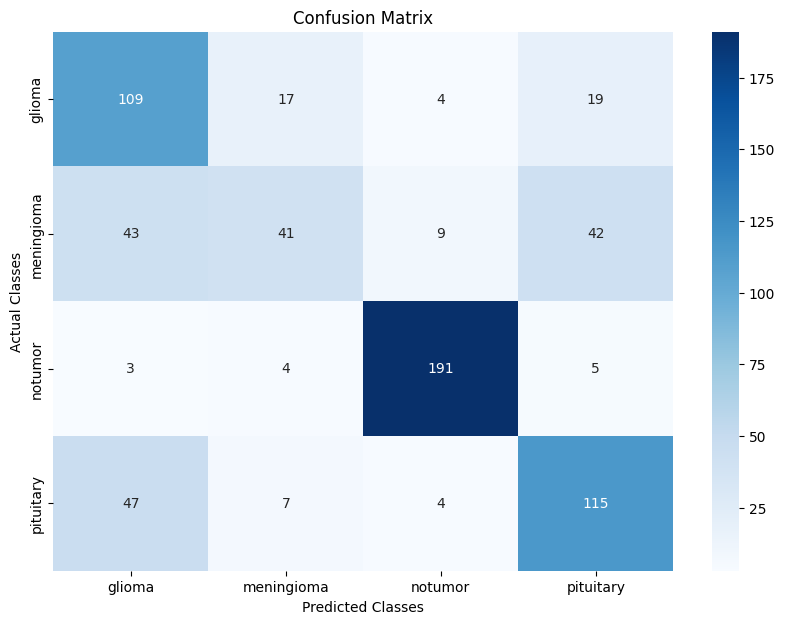

In [77]:
from tensorflow.keras.applications import ResNet50


# In[ ]:


WIDTH, HEIGHT = (224, 224)
resnet = ResNet50(weights='imagenet', include_top=False, input_shape=(WIDTH, HEIGHT, 3))

for layer in resnet.layers:
    layer.trainable = False


# In[ ]:


model_head = topLayer(bottom_layer=resnet.output, num_classes=NUM_CLASSES)
model_resnet = Model(inputs=resnet.input, outputs=model_head)
model_resnet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# In[ ]:


history = model_resnet.fit(X_train, y_train, epochs=20, batch_size=48, validation_data=(X_test, y_test))


# In[ ]:


loss, accuracy = model_resnet.evaluate(X_test, y_test)
print(f"Test loss: {loss}, Test accuracy: {accuracy}")


# In[ ]:


y_pred = model_resnet.predict(X_test, batch_size=32)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


# In[ ]:


# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 11s 131ms/step - accuracy: 0.6039 - loss: 1.5564 - val_accuracy: 0.9076 - val_loss: 0.2818
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - accuracy: 0.9192 - loss: 0.2304 - val_accuracy: 0.8970 - val_loss: 0.2834
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9368 - loss: 0.1725 - val_accuracy: 0.9227 - val_loss: 0.1941
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9613 - loss: 0.1209 - val_accuracy: 0.9242 - val_loss: 0.2033
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9640 - loss: 0.0986 - val_accuracy: 0.9258 - val_loss: 0.2013
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9742 - loss: 0.0798 - val_accuracy: 0.9091 - val_loss: 0.2472
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9827 - loss: 0.0588 - val_accuracy: 0.9318 - val_loss: 0.1923
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.9977 - loss: 0.0323 - val_accuracy: 0.9303 -

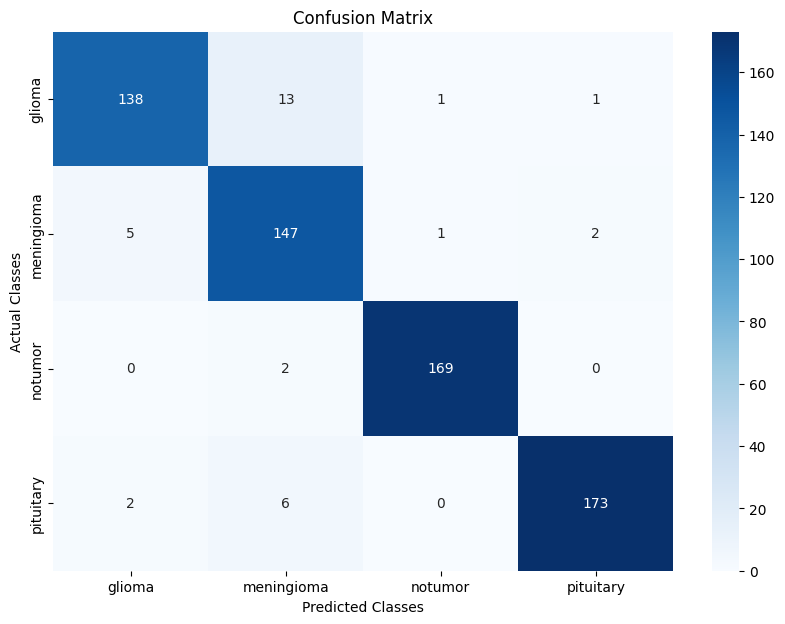

In [138]:

from tensorflow.keras.applications import MobileNet


# In[ ]:


mobile_net = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in mobile_net.layers:
    layer.trainable = False


# In[ ]:


x = mobile_net.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(len(sub_dirs), activation='softmax')(x)


# In[ ]:


model_mobilenet = Model(inputs=mobile_net.input, outputs=predictions)
model_mobilenet.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# In[ ]:


history = model_mobilenet.fit(X_train, y_train, epochs=20, batch_size=48, validation_data=(X_test, y_test))


# In[ ]:


loss, accuracy = model_mobilenet.evaluate(X_test, y_test)
print(f'Test accuracy: {accuracy}')


# In[ ]:


y_pred_mobilenet = model_mobilenet.predict(X_test)
y_pred_classes = np.argmax(y_pred_mobilenet, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


# In[ ]:


# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 29s 316ms/step - accuracy: 0.6088 - loss: 1.5597 - val_accuracy: 0.8318 - val_loss: 0.4191
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8312 - loss: 0.4135 - val_accuracy: 0.8606 - val_loss: 0.3766
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.8914 - loss: 0.3006 - val_accuracy: 0.8864 - val_loss: 0.3270
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9143 - loss: 0.2340 - val_accuracy: 0.8712 - val_loss: 0.3506
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9251 - loss: 0.2072 - val_accuracy: 0.8424 - val_loss: 0.4108
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 76ms/step - accuracy: 0.9071 - loss: 0.2472 - val_accuracy: 0.8970 - val_loss: 0.2893
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9563 - loss: 0.1299 - val_accuracy: 0.8879 - val_loss: 0.3124
Epoch 8/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 4s 77ms/step - accuracy: 0.9674 - loss: 0.1172 - val_accuracy: 0.9030 -

W0000 00:00:1714335320.187702     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Test loss: 0.29411429166793823, Test accuracy: 0.9242424368858337
21/21 ━━━━━━━━━━━━━━━━━━━━ 12s 293ms/step


W0000 00:00:1714335333.619677     119 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


              precision    recall  f1-score   support

           0       0.92      0.91      0.91       153
           1       0.88      0.85      0.87       155
           2       0.96      0.98      0.97       171
           3       0.93      0.95      0.94       181

    accuracy                           0.92       660
   macro avg       0.92      0.92      0.92       660
weighted avg       0.92      0.92      0.92       660



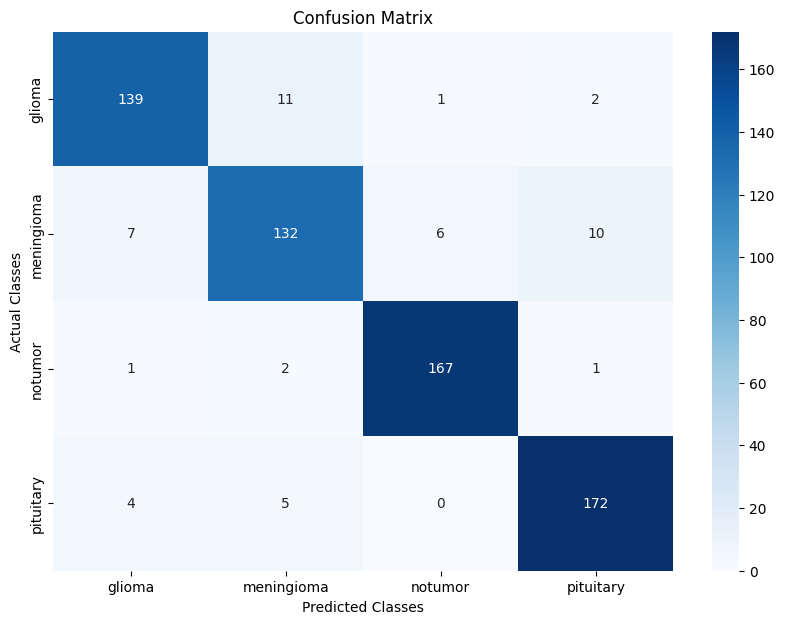

In [139]:


def topLayerInception(bottom_model, num_classes):
    """Add a custom top layer to the InceptionV3 base model."""
    top_layer = bottom_model.output
    top_layer = GlobalAveragePooling2D()(top_layer)
    top_layer = Dense(1024, activation='relu')(top_layer)
    top_layer = Dense(num_classes, activation='softmax')(top_layer)
    return top_layer


# In[ ]:


from keras.applications.inception_v3 import InceptionV3


# In[ ]:


WIDTH, HEIGHT = 299, 299


# In[ ]:


#base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))
base_model = InceptionV3(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))
# Set model layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False


# In[ ]:


model_head = topLayerInception(base_model, NUM_CLASSES)
model_inception = Model(inputs=base_model.input, outputs=model_head)

# Compile the model
model_inception.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# In[ ]:


history = model_inception.fit(X_train, y_train, epochs=20, batch_size=48, validation_data=(X_test, y_test))


# In[ ]:


loss, accuracy = model_inception.evaluate(X_test, y_test)
print(f'Test loss: {loss}, Test accuracy: {accuracy}')


# In[ ]:


y_pred_inception = model_inception.predict(X_test)
y_pred_classes = np.argmax(y_pred_inception, axis=1)
y_true = np.argmax(y_test, axis=1)

# Generate a classification report
print(classification_report(y_true, y_pred_classes))


# In[ ]:


# Generate the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('Actual Classes')
plt.xlabel('Predicted Classes')
plt.show()


In [143]:

# Ensemble predictions by averaging the probabilities
y_pred_ensemble = (y_pred_inception + y_pred_mobilenet) / 2

# Evaluate the ensemble predictions
ensemble_loss = keras.losses.categorical_crossentropy(y_test, y_pred_ensemble).numpy()
ensemble_accuracy = accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred_ensemble, axis=1))

print(f'Ensemble Test Loss: {ensemble_loss}, Ensemble Test Accuracy: {ensemble_accuracy}')

Ensemble Test Loss: [1.44337565e-02 1.81075861e-03 1.42244874e-02 1.54972201e-06
 5.12601264e-06 1.26944249e-02 1.66405514e-01 4.20415774e-03
 7.37641065e-04 1.18024160e-04 3.00411921e-05 2.96722148e-02
 2.13146699e-03 2.09939154e-03 4.22009798e-05 2.08022375e-05
 8.00028350e-03 8.74186109e-04 1.21989718e-03 2.73320023e-02
 1.19209304e-07 3.83060775e-03 4.03608024e-01 1.34111351e-05
 1.13830030e-01 8.34465368e-07 6.81036094e-04 6.79495270e-06
 1.66886076e-02 4.59418923e-04 2.38418608e-07 8.68604481e-02
 4.17232599e-07 1.19209304e-07 2.47687974e-04 1.77623424e-05
 1.79740831e-01 1.76431313e-05 2.96686683e-03 6.25868342e-05
 7.32332352e-04 1.99081496e-05 4.17232599e-07 1.04308674e-05
 7.15256022e-07 3.31456744e-04 7.19453965e-05 3.67488980e-01
 9.07684863e-02 7.74860666e-07 1.19209304e-07 1.44730555e-04
 5.62528032e-04 1.19209304e-07 2.49150526e-05 2.23319558e-03
 1.19209304e-07 2.20527560e-01 4.74923349e-04 3.07060461e-02
 3.57627925e-07 7.45060834e-06 7.18018040e-03 2.03305811e-01
 1.7

In [145]:
from sklearn.metrics import classification_report

# Convert one-hot encoded labels back to categorical labels
y_test_categorical = np.argmax(y_test, axis=1)
y_pred_ensemble_categorical = np.argmax(y_pred_ensemble, axis=1)

# Print classification report
print(classification_report(y_test_categorical, y_pred_ensemble_categorical, target_names=sub_dirs))


              precision    recall  f1-score   support

      glioma       0.95      0.92      0.93       153
  meningioma       0.90      0.92      0.91       155
     notumor       0.98      0.99      0.99       171
   pituitary       0.97      0.97      0.97       181

    accuracy                           0.95       660
   macro avg       0.95      0.95      0.95       660
weighted avg       0.95      0.95      0.95       660



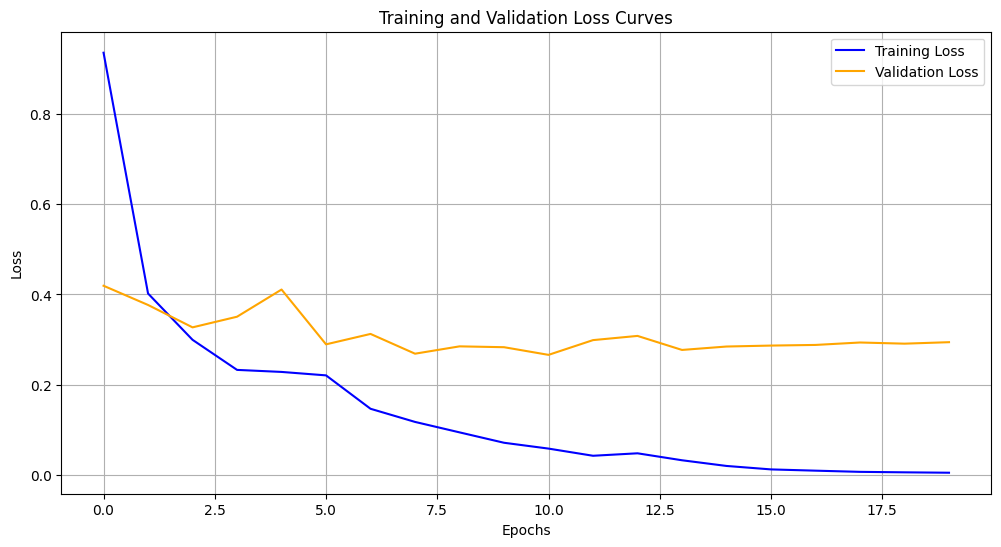

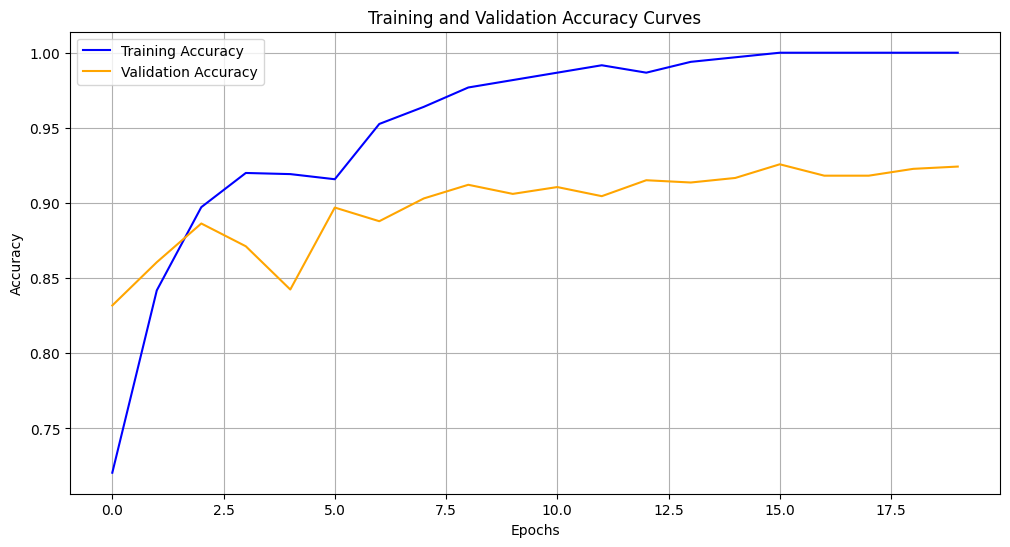

In [147]:
import matplotlib.pyplot as plt

# Plot training and validation loss curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Training and Validation Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Plot training and validation accuracy curves
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()
